In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
from tensorflow.keras import backend as K
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

tf.random.set_seed(1234)
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
MAX_NUM_WORDS = 1000
WORD_DIMENTIONS = 64
MAX_TEXT_LENGTH = 100
TOP_NUM = 10

## Download dataset leaving top 10 classes

In [3]:
def process_ds(x_train, y_train, x_test, y_test):
    x_tn, y_tn, x_tt, y_tt = [], [], [], []

    print(f'Original sizes: \t\ttrain, test - {len(y_train)}, {len(y_test)}')

    elements_count = collections.Counter(y_train)
    elements_count = {k: v for k, v in sorted(elements_count.items(), key=lambda item: item[1], reverse=True)}
    topN = list(elements_count.keys())[:TOP_NUM]

    for index, y in enumerate(y_train):
        if y in topN:
            x_tn.append(x_train[index])
            y_tn.append(topN.index(y))

    for index, y in enumerate(y_test):
        if y in topN:
            x_tt.append(x_train[index])
            y_tt.append(topN.index(y))

    print(f'After processing sizes: \ttrain, test - {len(y_tn)}, {len(y_tt)}')

    max_text_len = max([max([len(i) for i in x_tn]), max([len(i) for i in x_tt])])

    x_tn = tf.keras.preprocessing.sequence.pad_sequences(x_tn, maxlen=MAX_TEXT_LENGTH, padding="post")
    y_tn = np.array(y_tn)
    x_tt = tf.keras.preprocessing.sequence.pad_sequences(x_tt, maxlen=MAX_TEXT_LENGTH, padding="post")
    y_tt = np.array(y_tt)

    return x_tn, y_tn, x_tt, y_tt


def draw(data, metrics, model):
    plt.figure(figsize=(20,10))
    plt.title(f'{model} {metrics}')
    max_epochs = len(data.history[metrics])+1
    x = range(1, max_epochs)
    plt.plot(x, data.history[metrics])
    plt.plot(x, data.history[f'val_{metrics}'])
    plt.xticks(np.arange(1, max_epochs))
    plt.ylabel(metrics)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def draw_multiple(data, metrics, model):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()

    plt.title(f'{model} {metrics}')
    plt.xlabel('Epoch')
    plt.ylabel(metrics)

    max_epochs = len(data[0].history[metrics])+1
    x = range(1, max_epochs)
    plt.xticks(np.arange(1, max_epochs))

    for i, d in enumerate([100,1000,10000]):
        plt.plot(x, data[i].history[metrics], label=f'train, N = {d}')
        plt.plot(x, data[i].history[f'val_{metrics}'], label=f'test, N = {d}')
    plt.legend()
    plt.show()

In [4]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, validation):   
        super(Metrics, self).__init__()
        self.validation = validation    
            
        print('validation shape', len(self.validation[0]))
        
    def on_train_begin(self, logs={}):        
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
     
    def on_epoch_end(self, epoch, logs={}):
        val_targ = self.validation[1]   
        val_predict = (np.asarray(self.model.predict(self.validation[0]))).round()        
    
        val_f1 = f1_score(val_targ, val_predict)
        val_recall = recall_score(val_targ, val_predict)         
        val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(round(val_f1, 6))
        self.val_recalls.append(round(val_recall, 6))
        self.val_precisions.append(round(val_precision, 6))
 
        print(f' — val_f1: {val_f1} — val_precision: {val_precision}, — val_recall: {val_recall}')


class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [5]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(Embedding, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)

    def build(self, input_shape):
        self.embeddings = self.add_weight(  shape=(self.input_dim, self.output_dim),
                                            initializer=self.embeddings_initializer
                                            )    

    def call(self, inputs):
        out = tf.nn.embedding_lookup(self.embeddings, inputs)
        return out


In [6]:
class RNN(tf.keras.layers.Layer):
    def __init__(self, units):
        super(RNN, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.u = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.w = self.add_weight(shape=(self.units, self.units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='zeros')

    def call(self, inputs):
        initial_states = tf.keras.backend.zeros_like(inputs)
        initial_states = tf.keras.backend.sum(initial_states, axis=(1,2))
        initial_states = tf.keras.backend.expand_dims(initial_states)
        initial_states = [tf.keras.backend.tile(initial_states, [1, self.units])]

        input_length = tf.keras.backend.int_shape(inputs)[1]

        last_output, outputs, new_states = tf.keras.backend.rnn(step_function=self._step, inputs=inputs, initial_states=initial_states, input_length=input_length)

        return last_output

    def _step(self, inputs, states):
        new_output = tf.keras.backend.dot(inputs, self.u) + tf.keras.backend.dot(states[0], self.w) + self.b
        return new_output, [new_output]

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=MAX_NUM_WORDS)

x_train, y_train, x_test, y_test = process_ds(x_train, y_train, x_test, y_test)

Original sizes: 		train, test - 8982, 2246
After processing sizes: 	train, test - 7627, 1882


In [28]:
rnn_model = tf.keras.Sequential([
    Embedding(MAX_NUM_WORDS, WORD_DIMENTIONS),
    RNN(128),
    tf.keras.layers.Dense(units=TOP_NUM, activation='softmax')
])

rnn_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.00001),
                metrics=['accuracy'])
                # metrics=['acc',tfa.metrics.F1Score(num_classes=1,average="macro")])
                
history = rnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test), batch_size=128)

Epoch 1/10
60/60 [==============================] - 3s 58ms/step - loss: 2.2762 - accuracy: 0.0966 - val_loss: 2.1879 - val_accuracy: 0.2614
Epoch 2/10
60/60 [==============================] - 3s 57ms/step - loss: 2.0139 - accuracy: 0.3665 - val_loss: 2.0135 - val_accuracy: 0.3257
Epoch 3/10
60/60 [==============================] - 4s 60ms/step - loss: 1.8504 - accuracy: 0.4117 - val_loss: 1.9158 - val_accuracy: 0.3666
Epoch 4/10
60/60 [==============================] - 3s 57ms/step - loss: 1.7622 - accuracy: 0.4269 - val_loss: 1.8633 - val_accuracy: 0.3741
Epoch 5/10
60/60 [==============================] - 3s 56ms/step - loss: 1.7161 - accuracy: 0.4297 - val_loss: 1.8340 - val_accuracy: 0.3783
Epoch 6/10
60/60 [==============================] - 3s 57ms/step - loss: 1.6921 - accuracy: 0.4320 - val_loss: 1.8179 - val_accuracy: 0.3836
Epoch 7/10
60/60 [==============================] - 3s 56ms/step - loss: 1.6783 - accuracy: 0.4329 - val_loss: 1.8035 - val_accuracy: 0.3932
Epoch 8/10
60

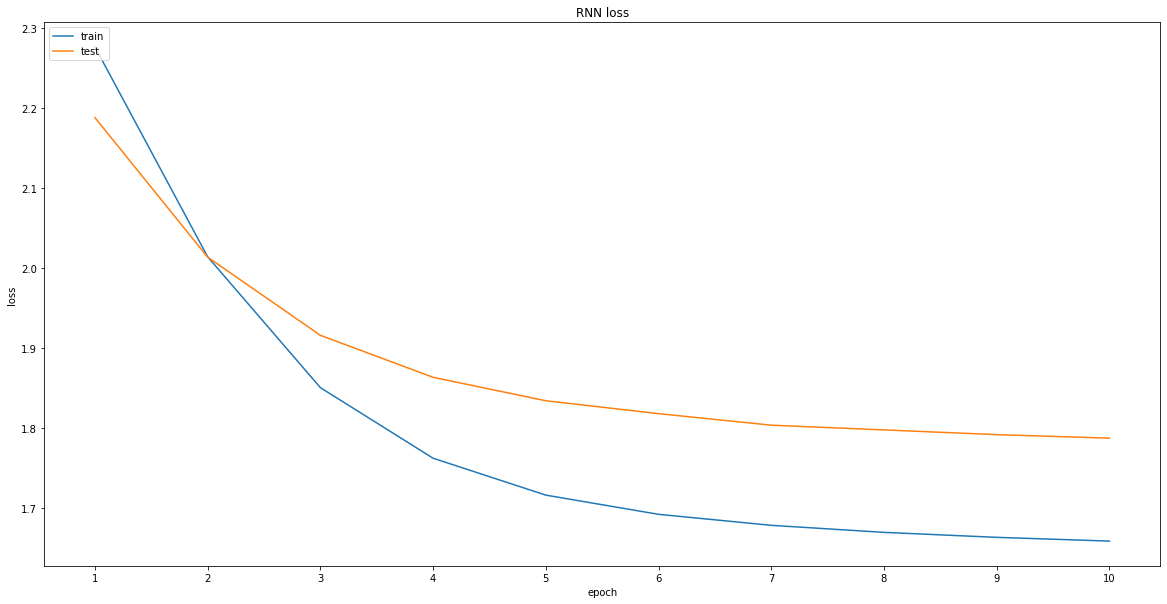

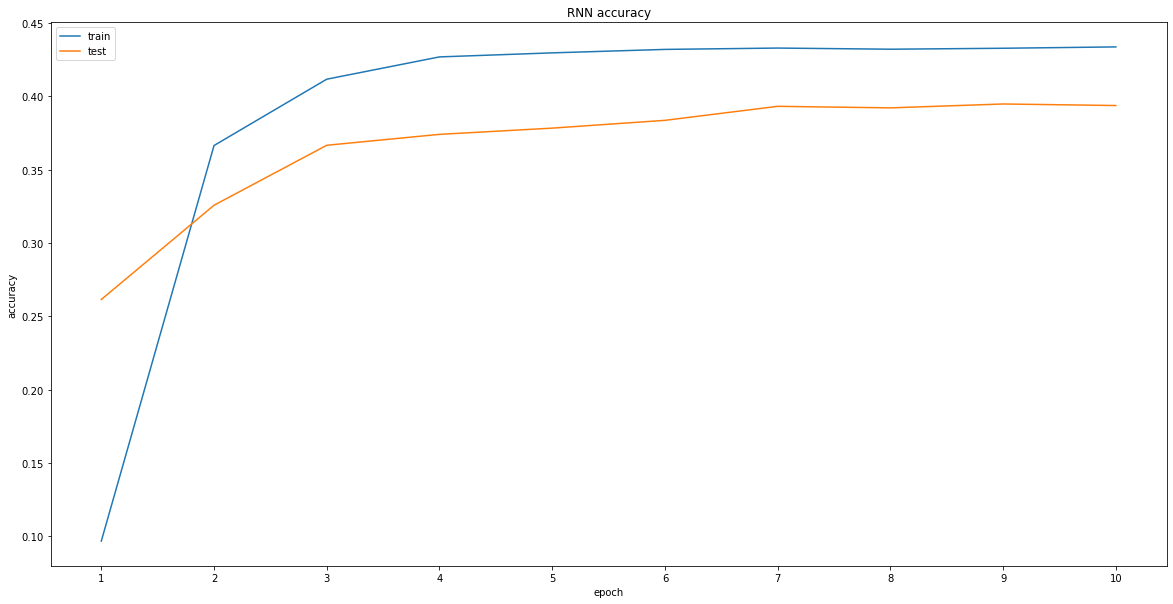

In [29]:
draw(history, 'loss', 'RNN')
draw(history, 'accuracy', 'RNN')

In [24]:
rnn_model = tf.keras.Sequential([
    Embedding(MAX_NUM_WORDS, WORD_DIMENTIONS),
    RNN(64),
    tf.keras.layers.Dense(units=TOP_NUM, activation='softmax')
])

rnn_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.00001),
                metrics=['accuracy'])
                # metrics=['acc',tfa.metrics.F1Score(num_classes=1,average="macro")])
                
history = rnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test), batch_size=128)

Epoch 1/10
60/60 [==============================] - 4s 58ms/step - loss: 2.3963 - accuracy: 0.0481 - val_loss: 2.3966 - val_accuracy: 0.0569
Epoch 2/10
60/60 [==============================] - 4s 59ms/step - loss: 2.2576 - accuracy: 0.2247 - val_loss: 2.2843 - val_accuracy: 0.2758
Epoch 3/10
60/60 [==============================] - 3s 57ms/step - loss: 2.1445 - accuracy: 0.3523 - val_loss: 2.1909 - val_accuracy: 0.2752
Epoch 4/10
60/60 [==============================] - 3s 56ms/step - loss: 2.0521 - accuracy: 0.3530 - val_loss: 2.1128 - val_accuracy: 0.2742
Epoch 5/10
60/60 [==============================] - 3s 56ms/step - loss: 1.9761 - accuracy: 0.3561 - val_loss: 2.0460 - val_accuracy: 0.2928
Epoch 6/10
60/60 [==============================] - 3s 57ms/step - loss: 1.9134 - accuracy: 0.3847 - val_loss: 1.9886 - val_accuracy: 0.3464
Epoch 7/10
60/60 [==============================] - 3s 57ms/step - loss: 1.8615 - accuracy: 0.4193 - val_loss: 1.9399 - val_accuracy: 0.3624
Epoch 8/10
60

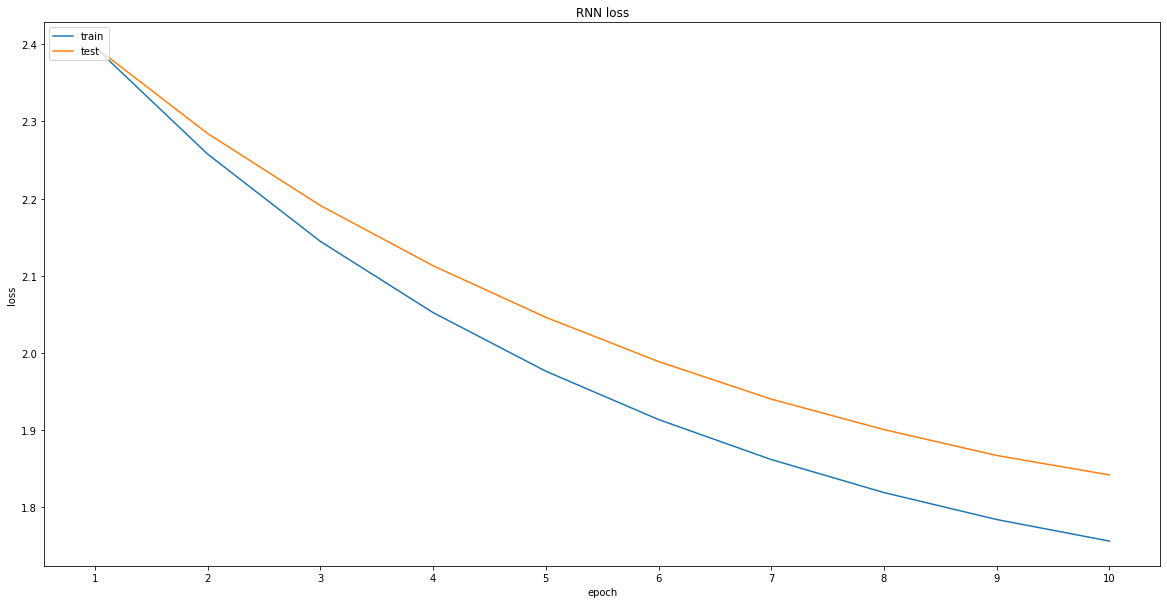

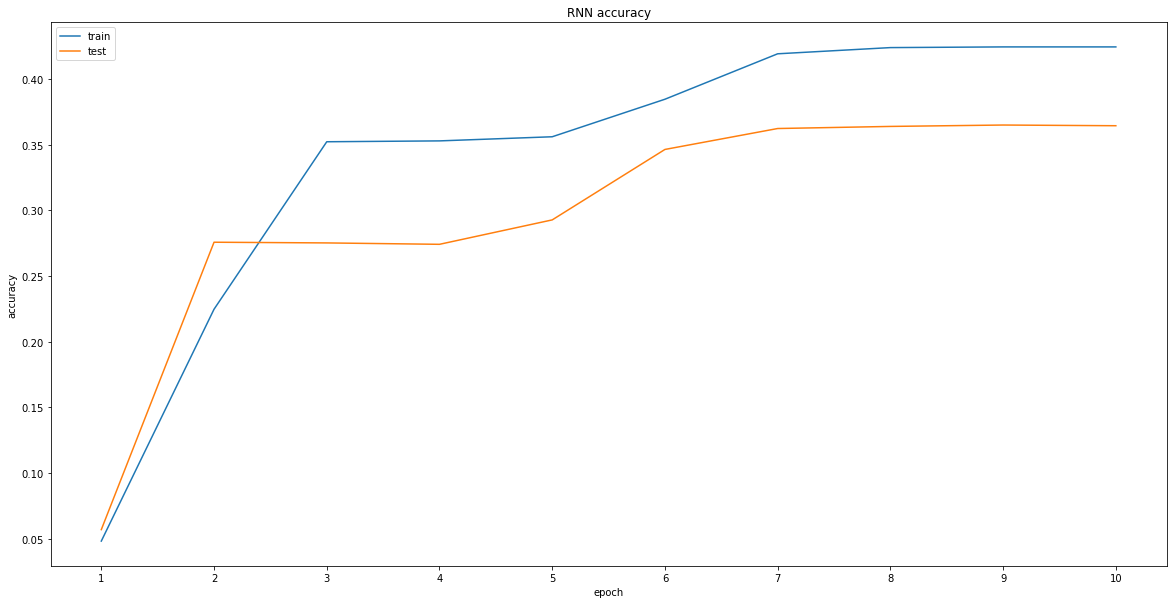

In [25]:
draw(history, 'loss', 'RNN')
draw(history, 'accuracy', 'RNN')

In [26]:
rnn_model = tf.keras.Sequential([
    Embedding(MAX_NUM_WORDS, WORD_DIMENTIONS),
    RNN(256),
    tf.keras.layers.Dense(units=TOP_NUM, activation='softmax')
])

rnn_model.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.00001),
                metrics=['accuracy'])
                # metrics=['acc',tfa.metrics.F1Score(num_classes=1,average="macro")])
                
history = rnn_model.fit(x_train, y_train, epochs=10, validation_data=(x_test,y_test), batch_size=128)

Epoch 1/10
60/60 [==============================] - 4s 62ms/step - loss: 2.3550 - accuracy: 0.2045 - val_loss: 2.0746 - val_accuracy: 0.3677
Epoch 2/10
60/60 [==============================] - 4s 59ms/step - loss: 1.9007 - accuracy: 0.3880 - val_loss: 1.9596 - val_accuracy: 0.3698
Epoch 3/10
60/60 [==============================] - 4s 60ms/step - loss: 1.7761 - accuracy: 0.3932 - val_loss: 1.8967 - val_accuracy: 0.3656
Epoch 4/10
60/60 [==============================] - 4s 59ms/step - loss: 1.7161 - accuracy: 0.4041 - val_loss: 1.8547 - val_accuracy: 0.3645
Epoch 5/10
60/60 [==============================] - 4s 59ms/step - loss: 1.6853 - accuracy: 0.4156 - val_loss: 1.8572 - val_accuracy: 0.3714
Epoch 6/10
60/60 [==============================] - 4s 60ms/step - loss: 1.6647 - accuracy: 0.4202 - val_loss: 1.8584 - val_accuracy: 0.3629
Epoch 7/10
60/60 [==============================] - 4s 60ms/step - loss: 1.6350 - accuracy: 0.4281 - val_loss: 1.9367 - val_accuracy: 0.3656
Epoch 8/10
60

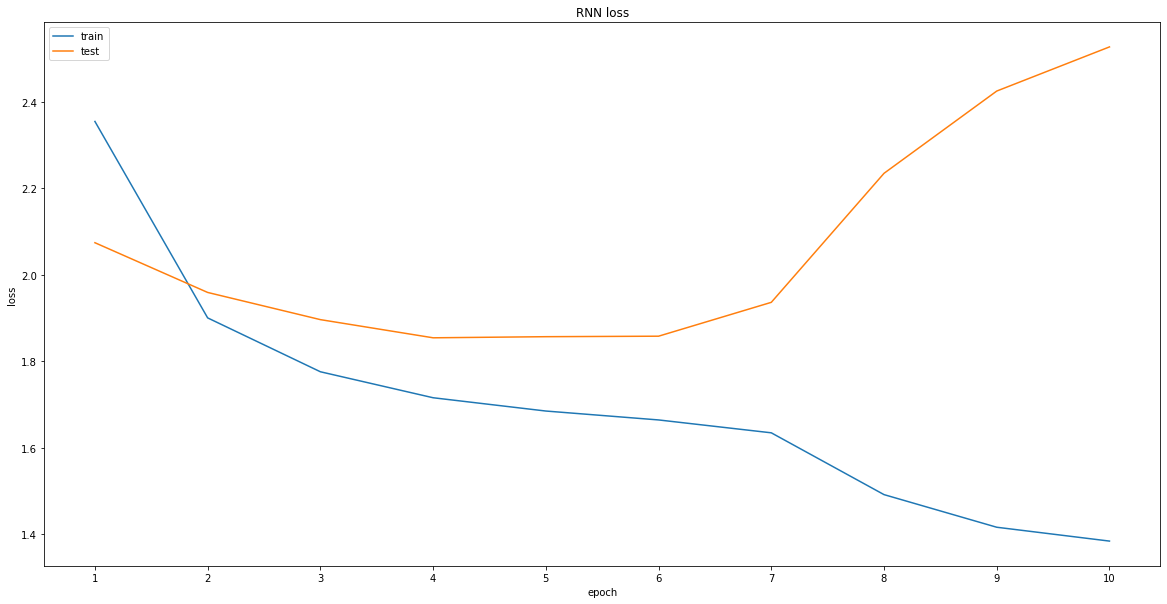

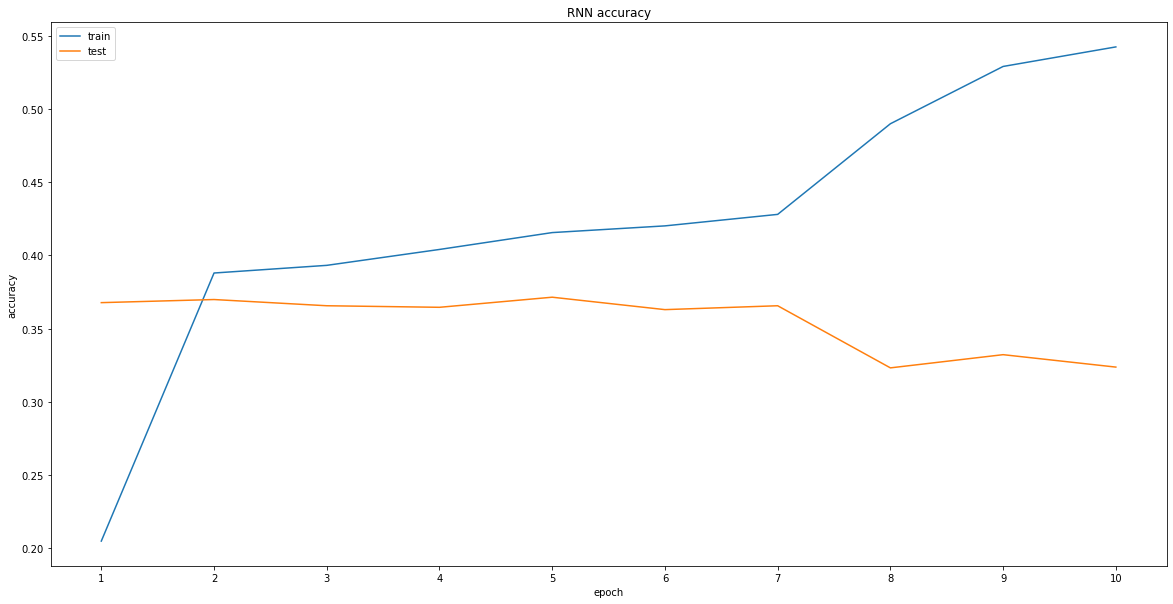

In [27]:
draw(history, 'loss', 'RNN')
draw(history, 'accuracy', 'RNN')

## Wnioski
Optymalna liczba neuronów warstwy RNN - 128.

Większa liczba neuronów (256) powoduje przeuczenie sieci.

Mniejsza liczba neuromów (64) powoduje mniejszą prękość i skuteczność uczenia sieci. Krzywa wykresu jest łamana.


| Liczba neuronów | Acc (train) | Acc (test) | Loss (train) | Loss (test) |
| --- | --- | --- | --- | --- |
| 64 | 0.42 | 0.36 | 1.75 | 1.84 |
| 128 | 0.43 | 0.39 | 1.65 | 1.78 |
| 256 | 0.54 | 0.32 | 1.38 | 2.53 |

Optymalny współczynnik uczenia - 0.00001. Mniejsza wartość współczynnika skutkuje tym, że model utyka się w lokalnym minimum i niezależnie od liczby epok nie polepsza wyników końcowych. Większa wartość - powoduje przeuczenie na zbiorze treningowym.

In [12]:
class LSTM(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LSTM, self).__init__()
        self.units = units
        
    def build(self, input_shape):   
        self.w_input_gate = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.w_input_hidden = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b_input = self.add_weight(shape=(self.units,), initializer="zeros")

        self.w_forget_gate = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.w_forget_hidden = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b_forget = self.add_weight(shape=(self.units,), initializer="zeros")

        self.w_output_gate = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.w_output_hidden = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b_output = self.add_weight(shape=(self.units,), initializer="zeros")

        self.w_memory_cell = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.w_memory_cell_hidden = self.add_weight(shape=(self.units, self.units), initializer="random_normal", trainable=True)
        self.b_memory_cell = self.add_weight(shape=(self.units,), initializer="zeros")
    
    def call(self, inputs):    
        initial_states = tf.keras.backend.zeros_like(inputs)
        initial_states = tf.keras.backend.sum(initial_states, axis=(1, 2))
        initial_states = tf.keras.backend.expand_dims(initial_states)
        initial_states = [tf.keras.backend.tile(initial_states, [1, self.units]),
               tf.keras.backend.tile(initial_states, [1, self.units])]

        input_length = tf.keras.backend.int_shape(inputs)[1]

        last_output, outputs, new_states = tf.keras.backend.rnn(step_function=self._step, inputs=inputs, initial_states=initial_states, input_length=input_length)
        return last_output

    def _step(self, inputs, states):
        input_gate = tf.sigmoid(tf.keras.backend.dot(inputs, self.w_input_gate) + tf.keras.backend.dot(states[0], self.w_input_hidden) + self.b_input)
        forget_gate = tf.sigmoid(tf.keras.backend.dot(inputs, self.w_forget_gate) + tf.keras.backend.dot(states[0], self.w_forget_hidden) + self.b_forget)
        output_gate = tf.sigmoid(tf.keras.backend.dot(inputs, self.w_output_gate) + tf.keras.backend.dot(states[0], self.w_output_hidden) + self.b_output)
        memory_cell = tf.tanh(tf.keras.backend.dot(inputs, self.w_memory_cell) + tf.keras.backend.dot(states[0], self.w_memory_cell_hidden) + self.b_memory_cell)
        
        state = forget_gate * states[1] + input_gate * memory_cell
        new_output = output_gate * tf.tanh(state)
        
        return new_output, [states[0], state] 

In [15]:
lstm_model = tf.keras.Sequential([
    Embedding(MAX_NUM_WORDS, WORD_DIMENTIONS),
    LSTM(128),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

history = lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128)

Epoch 1/10
60/60 [==============================] - 11s 188ms/step - loss: 2.0560 - accuracy: 0.3151 - val_loss: 1.9170 - val_accuracy: 0.3650
Epoch 2/10
60/60 [==============================] - 11s 185ms/step - loss: 1.7250 - accuracy: 0.4262 - val_loss: 1.8355 - val_accuracy: 0.3650
Epoch 3/10
60/60 [==============================] - 12s 197ms/step - loss: 1.6699 - accuracy: 0.4261 - val_loss: 1.8018 - val_accuracy: 0.3650
Epoch 4/10
60/60 [==============================] - 12s 197ms/step - loss: 1.6541 - accuracy: 0.4262 - val_loss: 1.7789 - val_accuracy: 0.3650
Epoch 5/10
60/60 [==============================] - 12s 195ms/step - loss: 1.6482 - accuracy: 0.4269 - val_loss: 1.7751 - val_accuracy: 0.3672
Epoch 6/10
60/60 [==============================] - 12s 195ms/step - loss: 1.6457 - accuracy: 0.4276 - val_loss: 1.7758 - val_accuracy: 0.3666
Epoch 7/10
60/60 [==============================] - 12s 197ms/step - loss: 1.6441 - accuracy: 0.4287 - val_loss: 1.7668 - val_accuracy: 0.3746

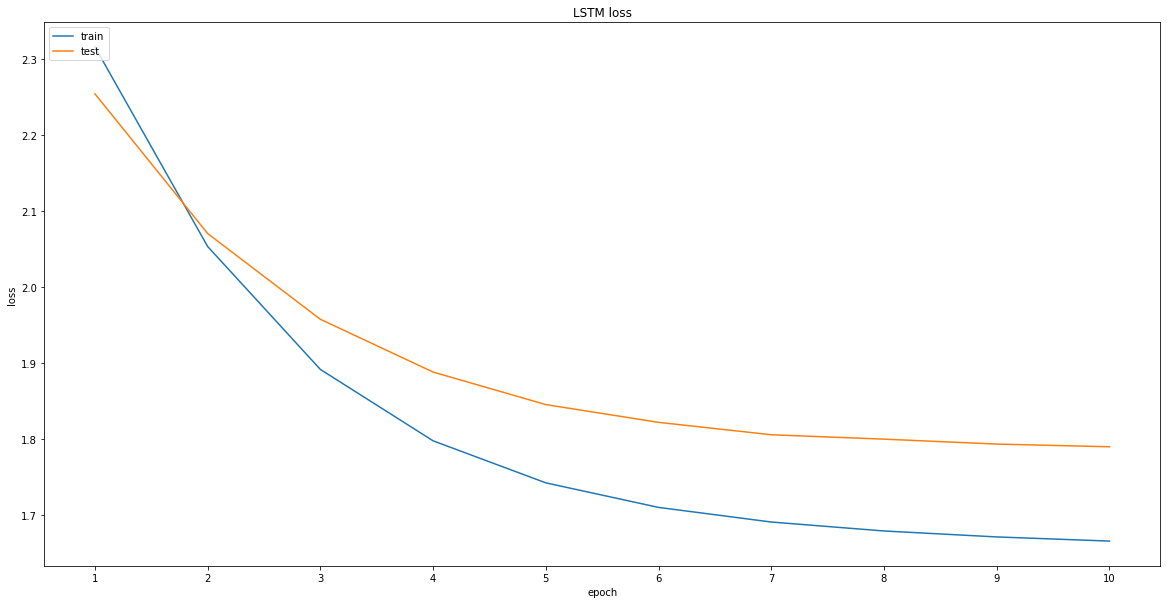

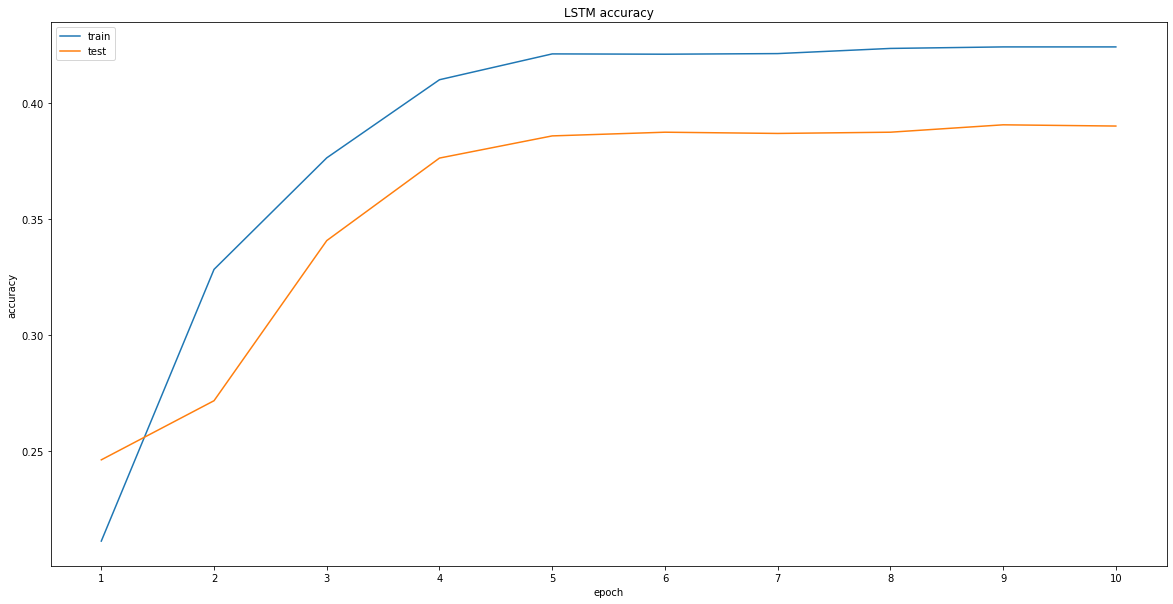

In [20]:
draw(history, 'loss', 'LSTM')
draw(history, 'accuracy', 'LSTM')

In [33]:
lstm_model = tf.keras.Sequential([
    Embedding(MAX_NUM_WORDS, WORD_DIMENTIONS),
    LSTM(64),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

history = lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128)

Epoch 1/10
60/60 [==============================] - 12s 205ms/step - loss: 2.0886 - accuracy: 0.3223 - val_loss: 1.9961 - val_accuracy: 0.3650
Epoch 2/10
60/60 [==============================] - 12s 203ms/step - loss: 1.8049 - accuracy: 0.4261 - val_loss: 1.8686 - val_accuracy: 0.3650
Epoch 3/10
60/60 [==============================] - 12s 200ms/step - loss: 1.7034 - accuracy: 0.4261 - val_loss: 1.8188 - val_accuracy: 0.3650
Epoch 4/10
60/60 [==============================] - 12s 195ms/step - loss: 1.6708 - accuracy: 0.4261 - val_loss: 1.7893 - val_accuracy: 0.3650
Epoch 5/10
60/60 [==============================] - 11s 191ms/step - loss: 1.6574 - accuracy: 0.4261 - val_loss: 1.7778 - val_accuracy: 0.3650
Epoch 6/10
60/60 [==============================] - 11s 191ms/step - loss: 1.6516 - accuracy: 0.4261 - val_loss: 1.7750 - val_accuracy: 0.3650
Epoch 7/10
60/60 [==============================] - 12s 192ms/step - loss: 1.6483 - accuracy: 0.4262 - val_loss: 1.7662 - val_accuracy: 0.3650

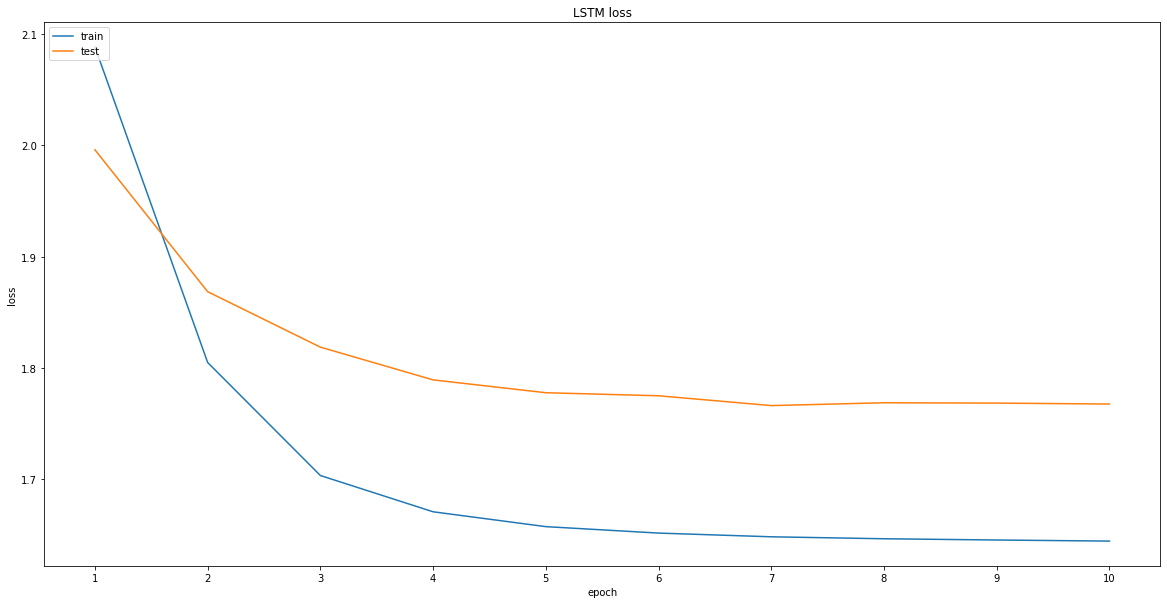

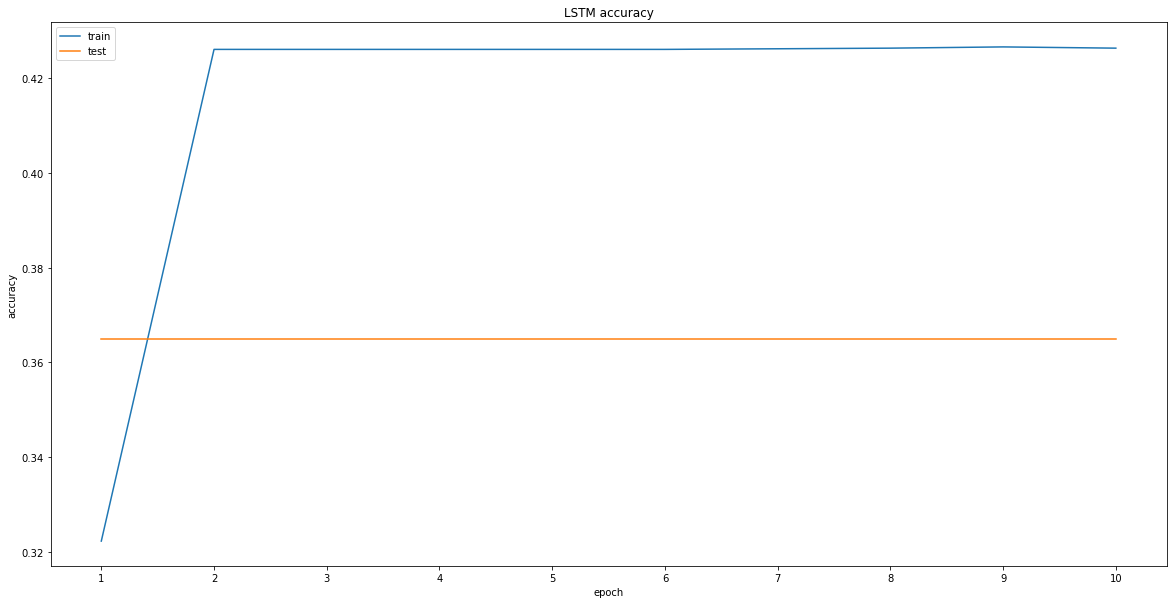

In [34]:
draw(history, 'loss', 'LSTM')
draw(history, 'accuracy', 'LSTM')

In [35]:
lstm_model = tf.keras.Sequential([
    Embedding(MAX_NUM_WORDS, WORD_DIMENTIONS),
    LSTM(256),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

history = lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128)

Epoch 1/10
60/60 [==============================] - 13s 209ms/step - loss: 1.8979 - accuracy: 0.4058 - val_loss: 1.8460 - val_accuracy: 0.3661
Epoch 2/10
60/60 [==============================] - 12s 206ms/step - loss: 1.6738 - accuracy: 0.4243 - val_loss: 1.7808 - val_accuracy: 0.3645
Epoch 3/10
60/60 [==============================] - 12s 202ms/step - loss: 1.6497 - accuracy: 0.4262 - val_loss: 1.7742 - val_accuracy: 0.3634
Epoch 4/10
60/60 [==============================] - 12s 203ms/step - loss: 1.6464 - accuracy: 0.4264 - val_loss: 1.7645 - val_accuracy: 0.3629
Epoch 5/10
60/60 [==============================] - 12s 204ms/step - loss: 1.6448 - accuracy: 0.4289 - val_loss: 1.7727 - val_accuracy: 0.3640
Epoch 6/10
60/60 [==============================] - 13s 211ms/step - loss: 1.6438 - accuracy: 0.4270 - val_loss: 1.7747 - val_accuracy: 0.3645
Epoch 7/10
60/60 [==============================] - 14s 229ms/step - loss: 1.6428 - accuracy: 0.4270 - val_loss: 1.7640 - val_accuracy: 0.3789

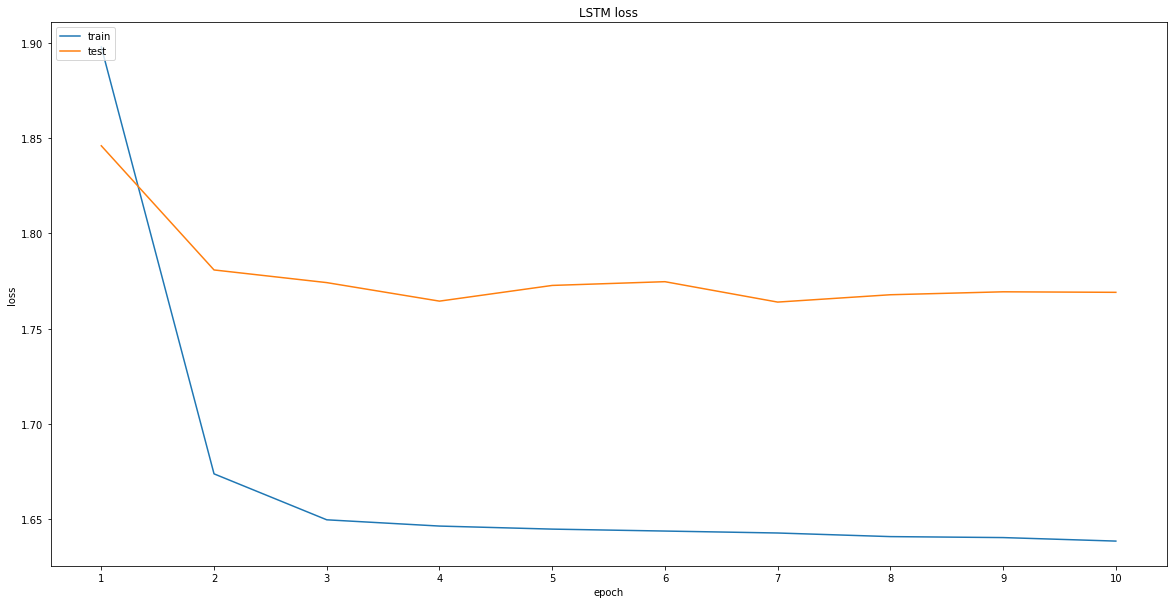

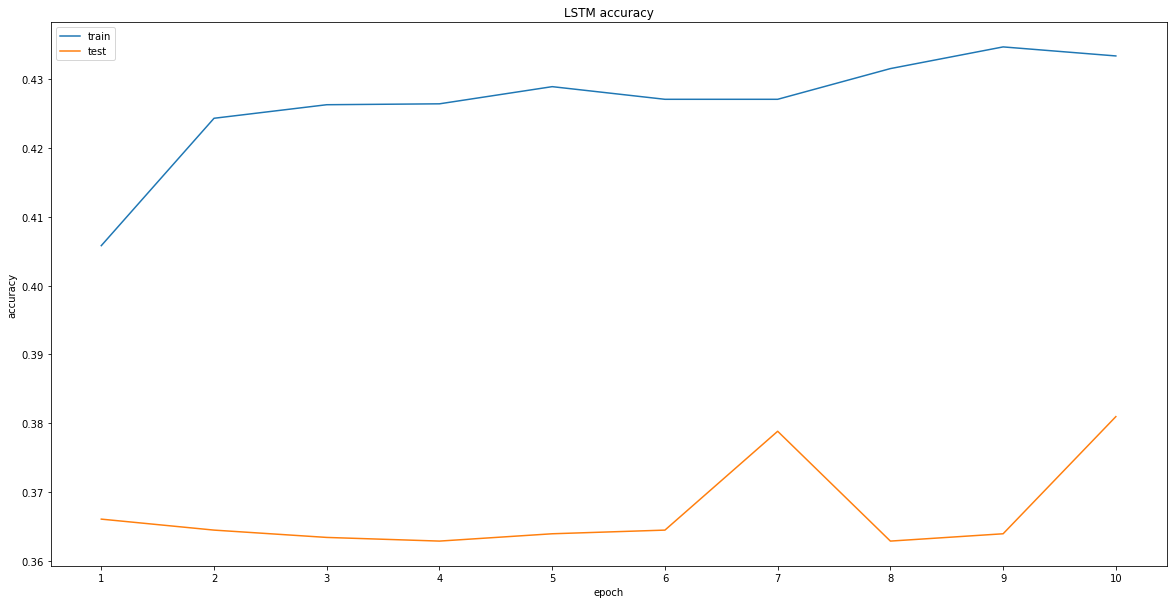

In [36]:
draw(history, 'loss', 'LSTM')
draw(history, 'accuracy', 'LSTM')

## Wnioski

| Liczba neuronów | Acc (train) | Acc (test) | Loss (train) | Loss (test) |
| --- | --- | --- | --- | --- |
| 64 | 0.43 | 0.37 | 1.64 | 1.77 |
| 128 | 0.43 | 0.39 | 1.65 | 1.78 |
| 256 | 0.43 | 0.38 | 1.63 | 1.76 |

Niezależnie od liczby neuronów warstwy LSTM - wyniki końcowe sieci mało czym się róźnią.

In [21]:
max_nums_words = [100,1000,10000]
results = []

for max_num_words in max_nums_words:

    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=max_num_words)
    x_train, y_train, x_test, y_test = process_ds(x_train, y_train, x_test, y_test)

    lstm_model = tf.keras.Sequential([
        Embedding(max_num_words, WORD_DIMENTIONS),
        LSTM(128),
        tf.keras.layers.Dense(units=10, activation='softmax')
    ])

    lstm_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

    results.append(lstm_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=128))

Original sizes: 		train, test - 8982, 2246
After processing sizes: 	train, test - 7627, 1882
Epoch 1/10
60/60 [==============================] - 11s 191ms/step - loss: 2.0123 - accuracy: 0.3658 - val_loss: 1.8921 - val_accuracy: 0.3650
Epoch 2/10
60/60 [==============================] - 11s 189ms/step - loss: 1.7138 - accuracy: 0.4259 - val_loss: 1.7948 - val_accuracy: 0.3650
Epoch 3/10
60/60 [==============================] - 11s 187ms/step - loss: 1.6610 - accuracy: 0.4259 - val_loss: 1.7760 - val_accuracy: 0.3650
Epoch 4/10
60/60 [==============================] - 11s 185ms/step - loss: 1.6513 - accuracy: 0.4256 - val_loss: 1.7646 - val_accuracy: 0.3645
Epoch 5/10
60/60 [==============================] - 11s 186ms/step - loss: 1.6480 - accuracy: 0.4266 - val_loss: 1.7691 - val_accuracy: 0.3645
Epoch 6/10
60/60 [==============================] - 11s 187ms/step - loss: 1.6467 - accuracy: 0.4260 - val_loss: 1.7731 - val_accuracy: 0.3650
Epoch 7/10
60/60 [==============================]

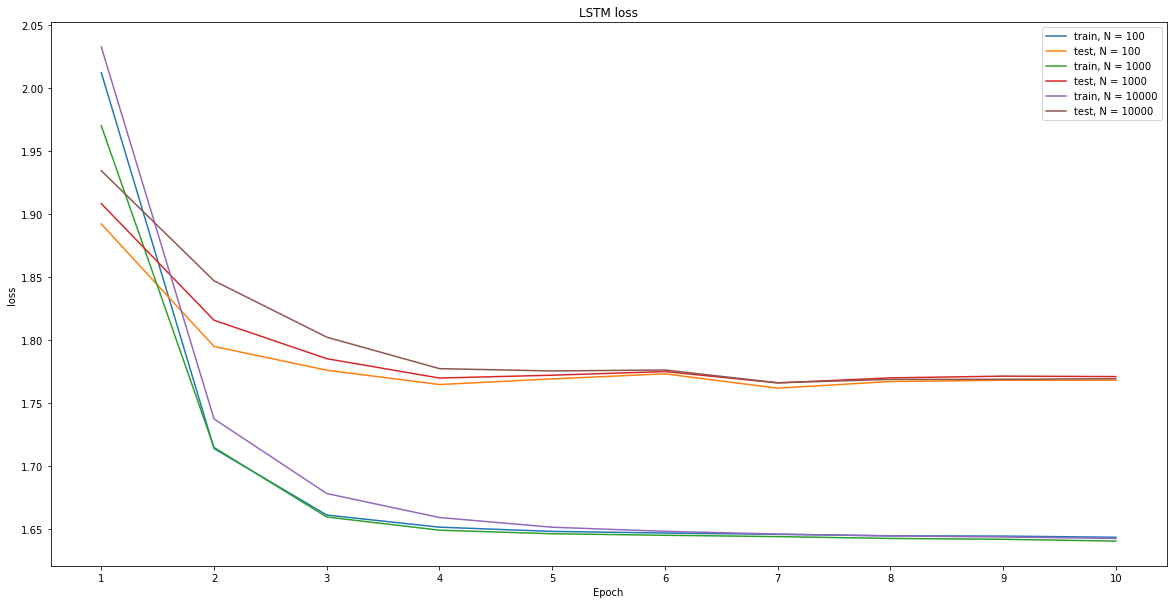

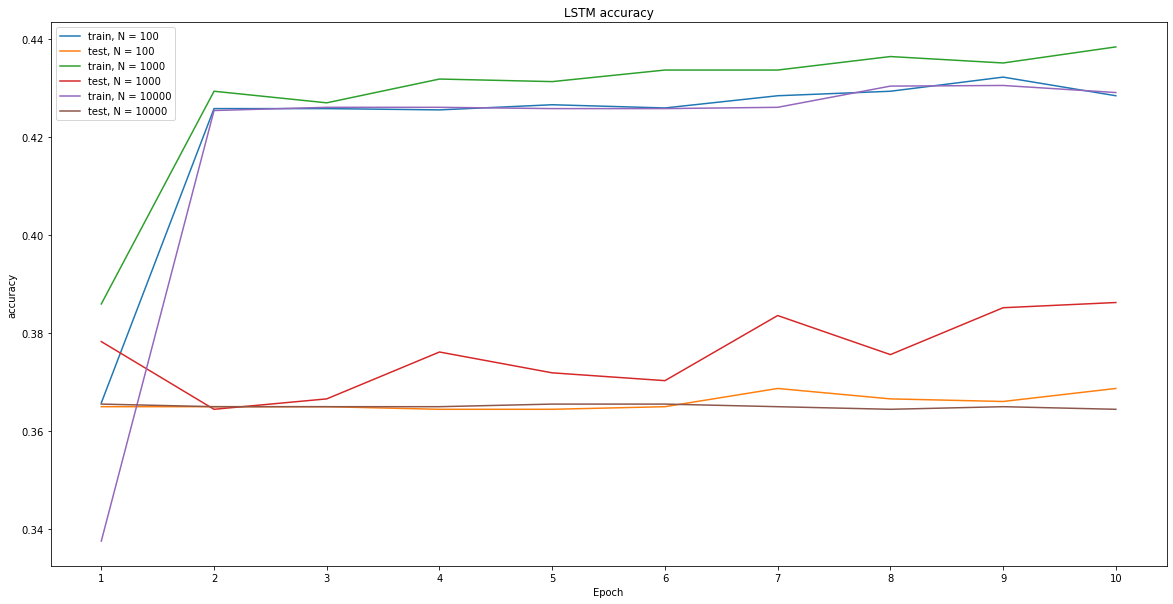

In [22]:
draw_multiple(results, 'loss', 'LSTM')
draw_multiple(results, 'accuracy', 'LSTM')

## Wnioski

Straty sieci są na tym samym poziomie (loss train / loss test : 1.64 / 1.76) niezależnie od wybranej maksymalnej liczby słów. 

Wyniki miary accuracy są najleprze (acc train / acc test : 0.44 / 0.39), kiedy maksymalna liczba słów równa się 1000.